In [1]:
! pip install pykalman

  Using cached pykalman-0.9.5-py3-none-any.whl


## Example

In [7]:
from pykalman import KalmanFilter
import numpy as np
kf = KalmanFilter(transition_matrices = [[1, 1], [0, 1]], observation_matrices = [[0.1, 0.5], [-0.3, 0.0]])
measurements = np.asarray([[1,0], [0,0], [0,1]])  # 3 observations
kf = kf.em(measurements, n_iter=5)
# (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
# (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
kf.__dict__

{'transition_matrices': array([[1, 1],
        [0, 1]]),
 'observation_matrices': array([[ 0.1,  0.5],
        [-0.3,  0. ]]),
 'transition_covariance': array([[1.3939454 , 0.00828761],
        [0.00828761, 0.3269986 ]]),
 'observation_covariance': array([[ 0.34180639, -0.07294099],
        [-0.07294099,  0.18519393]]),
 'transition_offsets': array([0., 0.]),
 'observation_offsets': array([0., 0.]),
 'initial_state_mean': array([-0.62893648,  0.36286253]),
 'initial_state_covariance': array([[ 0.28058382, -0.06524256],
        [-0.06524256,  0.11905581]]),
 'random_state': None,
 'em_vars': ['transition_covariance',
  'observation_covariance',
  'initial_state_mean',
  'initial_state_covariance'],
 'n_dim_state': 2,
 'n_dim_obs': 2}

## Comparison

In [8]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


# Seeds
from numpy.random import Generator, PCG64
rng = Generator(PCG64(1897))
MY_SEEDS = rng.integers(0,high=10**8,size=100)


import KSEM
from importlib import reload  
KSEM = reload(KSEM)
from KSEM import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

In [9]:
IBMQ.load_account()

<ipython-input-9-beb09c0bf764>:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [10]:
provider = IBMQ.get_provider(hub="ibm-q-ncsu", group="lehigh-universit", project="qc-error-model") # ibm-q-ncsu/lehigh-universit/qc-error-model
name = "ibm_nairobi"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 1
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

n_qubits = 3
reps = 8
max_num_itrs = 10

In [11]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.barrier()
    iterate.cx(1,2)
    iterate.cx(0,1)
    iterate.h(0)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

In [12]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)
    
trans_circ = transpile(iterative_circ(3, n_qubits), backend=den_simu)
iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()

total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = True), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    total_simu_probs.append(KSEM.dictToVec(iter_res.get_counts()))
    total_simu_purs.append(np.real(iter_den.purity()))

In [13]:
initial_state = np.array([0]*(total_simu_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [14]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = total_simu_probs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.01 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.1 * (1)# 
# U = np.identity(num_dim_obs, dtype=complex)* 0.0

In [22]:
# Use existing code to construct arguemented system
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)

In [37]:
kfobj_for_em = KalmanFilter(transition_matrices = learn_obj.Fa.todense().real, observation_matrices = learn_obj.Ha.todense().real)
measurements = np.asarray(learn_obj.ys)
kfobj_for_em = kfobj_for_em.em(measurements, n_iter=8)
kfobj_for_em.__dict__

{'transition_matrices': array([[ 1.00000000e+00,  3.12528683e-32,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.59047716e-32,  1.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  1.00000000e+00, -5.59047716e-32],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -3.12528683e-32,  1.00000000e+00]]),
 'observation_matrices': array([[0.5, 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 

In [38]:
(smoothed_state_means, smoothed_state_covariances) = kfobj_for_em.smooth(measurements)

In [42]:
smoothed_state_means.shape

(10, 128)

In [41]:
smoothed_state_covariances.shape

(10, 128, 128)

10

In [67]:
norm_diffs = []

for i in range(len(total_simu_dens)):
    kf_state = smoothed_state_means[i][:num_dim_state].flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F')
    norm_diff = np.linalg.norm(kf_state - total_simu_dens[i].data)
    norm_diffs.append(norm_diff)
    print(norm_diff)

0.13020343372549129
0.11839717607633954
0.11415426670551647
0.11087506451964955
0.10708709488665559
0.10464748738965451
0.10242318106129374
0.10040324206114329
0.09871178911490527
0.09387191125871336


In [59]:
kf_state

array([[ 8.63652946e-01,  2.03116971e-17, -4.72620701e-17,
         1.36786546e-17, -1.49669951e-17,  4.50661173e-17,
        -1.85969330e-17, -4.56363934e-17],
       [ 1.40585038e-15,  3.44392930e-02,  1.61183003e-17,
         3.94594322e-17,  2.70723855e-17, -2.04543712e-17,
        -1.68047639e-17, -2.92227944e-17],
       [-1.51185577e-15, -4.27387206e-18,  1.62031272e-02,
        -7.33465249e-19, -4.62177422e-17,  5.17056566e-17,
         2.39410183e-17, -6.48254547e-17],
       [ 4.73414865e-16,  3.71854575e-17, -2.67748735e-17,
         4.79058659e-03, -2.02091803e-17,  7.18011166e-17,
         3.67884462e-17, -5.56224345e-17],
       [-6.45347257e-17,  3.86478820e-18, -1.38465347e-18,
         2.42452955e-17,  6.96273722e-02, -1.87475751e-17,
         6.73662071e-18,  1.01800259e-16],
       [-3.10552834e-17,  1.53254971e-17, -6.24179051e-17,
         1.24660138e-17,  4.85076744e-18,  4.87295395e-03,
         1.64300028e-17, -6.94497810e-18],
       [-3.58522930e-17,  1.341673

In [62]:
# Use own codes
total_smoother_dens = []
total_smoother_purs = []

observs = total_simu_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
# realX0 = realX0.flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F') # to matrix
# realX0 = KSEM.closed_den_mat(realX0) # find closest valid density matrix
# realX0 = np.array(realX0.flatten(order='C'))[0] # reshape to vector

realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

Iteration statrts New ll 777.14, Last ll 767.14
Iteration     1, New log-likelihood 8.33713e+02, Last log-likelihood 7.77145e+02, Change 5.65687e+01
Iteration     2, New log-likelihood 8.88872e+02, Last log-likelihood 8.33713e+02, Change 5.51586e+01
Iteration     3, New log-likelihood 9.43637e+02, Last log-likelihood 8.88872e+02, Change 5.47649e+01
Iteration     4, New log-likelihood 9.97990e+02, Last log-likelihood 9.43637e+02, Change 5.43530e+01
Iteration     5, New log-likelihood 1.05187e+03, Last log-likelihood 9.97990e+02, Change 5.38814e+01
Iteration     6, New log-likelihood 1.10527e+03, Last log-likelihood 1.05187e+03, Change 5.33982e+01
Iteration     7, New log-likelihood 1.15816e+03, Last log-likelihood 1.10527e+03, Change 5.28867e+01
Iteration     8, New log-likelihood 1.21043e+03, Last log-likelihood 1.15816e+03, Change 5.22710e+01
Iteration     9, New log-likelihood 1.26196e+03, Last log-likelihood 1.21043e+03, Change 5.15328e+01
Iteration    10, New log-likelihood 1.17092

In [63]:
smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 

In [68]:
norm_diffs2 = []
for i in range(len(total_simu_dens)):
    kf_state2 = x_seq[i].todense()[:num_dim_state].flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F')
    norm_diff = np.linalg.norm(kf_state2 - total_simu_dens[i].data)
    norm_diffs2.append(norm_diff)
    print(norm_diff)

0.10535861970678731
0.10192863822213453
0.09464731045000428
0.0946572044347576
0.09646526181649794
0.09268073915561517
0.09202129851231865
0.09272718754260346
0.09430132827621955
0.09485017452147511


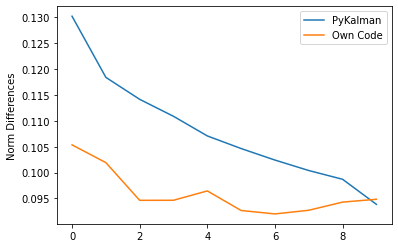

In [73]:
plt.plot(list(range(10)), norm_diffs, label='PyKalman')
plt.plot(list(range(10)), norm_diffs2, label='Own Code')
plt.ylabel('Norm Differences')
plt.legend()
plt.show()

In [74]:
# State tomogtaphy

backend_noise_model_for_tomo = NoiseModel.from_backend(backend)
# Remove readout errros
p0given1 = 0
p1given0 = 0
rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
for i in range(backend.configuration().num_qubits):
    backend_noise_model_for_tomo._local_readout_errors[(i,)] = rde
den_simu_for_tomo = AerSimulator(method='density_matrix',noise_model=backend_noise_model_for_tomo)


tomo_dens = [] # quantum state in density-matrix form
tomo_probs = [] # measurement result
tomo_purs = [] # purity
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    tomo_target_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu_for_tomo,optimization_level=0)
    qstexp = StateTomography(tomo_target_circ)
    qstdata = qstexp.run(den_simu, seed_simulation=my_seed).block_for_results()
    tomo_state =  qstdata.analysis_results("state")
    
    tomo_dens.append(tomo_state.value.data)
    tomo_probs.append(tomo_state.value.probabilities())
    tomo_purs.append(np.real(tomo_state.value.purity()))

In [77]:
norm_diffs3 = []
for i in range(len(total_simu_dens)):
    norm_diff = np.linalg.norm(tomo_dens[i] - total_simu_dens[i].data)
    norm_diffs3.append(norm_diff)
    print(norm_diff)

0.14962667641517371
0.14532326816693444
0.15194130480853776
0.1391835491499797
0.15063189310236783
0.1257097134921955
0.1507667739776124
0.14185558492141517
0.13998952086160604
0.14136861240911877


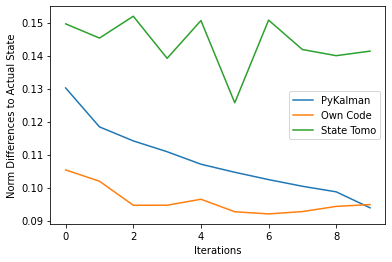

In [80]:
plt.plot(list(range(10)), norm_diffs, label='PyKalman')
plt.plot(list(range(10)), norm_diffs2, label='Own Code')
plt.plot(list(range(10)), norm_diffs3, label='State Tomo')
plt.xlabel('Iterations')
plt.ylabel('Norm Differences to Actual State')
plt.legend()
plt.show()